# Data Ingestion Pipeline

### Loading npy(s)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [2]:
processed_dataset  = "processed_data"

In [3]:
from scipy.ndimage import zoom
import os

# numero di sample richiesti
N = len(next(os.walk("%s/voxelizations" % processed_dataset))[2])


# carico il training set
print("Caricamento training set...")

voxelizations      = []
voxelization_specs = []
centers_of_mass    = []
finger_prints      = []
anchors            = []

for i in range(N):
    voxelization       = jnp.array(np.load("%s/voxelizations/voxelization_%d.npy"           % (processed_dataset,i)))
    voxelization_spec  = jnp.array(np.load("%s/voxelization_specs/voxelization_spec_%d.npy" % (processed_dataset,i)))
    center_of_mass     = jnp.array(np.load("%s/centers_of_mass/center_of_mass_%d.npy"       % (processed_dataset,i)))
    finger_print       = jnp.array(np.load("%s/finger_prints/finger_print_%d.npy"           % (processed_dataset,i)))
    anchor             = jnp.array(np.load("%s/anchors/anchor_%d.npy"                       % (processed_dataset,i)))
    
    voxelization_specs.append(voxelization_spec)
    voxelizations.append(voxelization)
    centers_of_mass.append(center_of_mass)
    finger_prints.append(finger_print)
    anchors.append(anchor)
    
    if int( i / (N / 10)) != int( (i + 1)/ (N/10) ):
        print("%d su %d" % (i , N))

Caricamento training set...
30 su 301
60 su 301
90 su 301
120 su 301
150 su 301
180 su 301
210 su 301
240 su 301
270 su 301
300 su 301


# Train Test Split

In [4]:
indici_train = np.arange(len(voxelizations)) < int(len(voxelizations) * .8)
indici_test  = ~indici_train         

# Subvoxelgrid Transform
Che tipo di trasformazione bisogna applicare alla subvoxel grid estratta prima di utilizzarla?

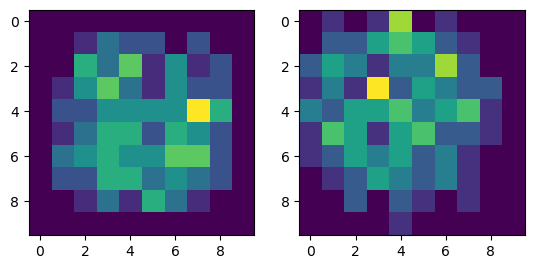

In [5]:
class SubvoxelgridTransform:
    def __init__(self,n):
        self.grid = self._init_grid(n)
        self.ball = self._emptyball(n)
    
    def _init_grid(self,n):
        return np.array(
        [
            [
                [
                    [x,y,z]
                    for z  in np.linspace(0,1,2*n)
                ]
                for y  in np.linspace(0,1,2*n)
            ]
            for x  in np.linspace(0,1,2*n)
        ]
        )

    def _emptyball(self,n):
        r = np.array([
            [
                [
                        (i**2 + j**2 + k**2) <= 1
                    for k in np.linspace(-1,1,2*n)
                ]
                for j in np.linspace(-1,1,2*n)
            ]
            for i in np.linspace(-1,1,2*n)
        ])
        return r
    
    ##############################################################################################
    
    def identity(self,SV):
        return SV
    
    
    def rotational_invariance(self,SV):
        # calcolo i nuovi punti
        points = self.grid[ (SV * self.ball) > 0.5].reshape(-1,3)
        if len(points) < 2.:
            # non ci sono atomi nella selezione!
            return SV

        points = points - points.mean(axis = 0)

        original_points = points.copy()

        U,s,Vt = np.linalg.svd(points)


        projection = points @ Vt.T
        classifica = np.argmax( np.abs(projection), axis = 0)
        S  =   np.sign( projection[classifica,[0,1,2]] )
        V  =   S[None,:] * Vt.T
        points = points @ V

        ## costruisco la voxelgrid
        ret  = np.zeros(self.grid.shape[:-1])

        stdpoints = (points - points.min()) / (points.max() - points.min())


        for p in stdpoints:
                i = int(p[0] * (SV.shape[0] - 1) )
                j = int(p[1] * (SV.shape[1] - 1) )
                k = int(p[2] * (SV.shape[2] - 1) )
                ret[i,j,k] = 1.
        return ret

A = np.random.uniform(size = (10,10,10))
axs = plt.figure().subplots(nrows = 1,ncols = 2).flatten()
axs[0].imshow(( (A>0.5) * SubvoxelgridTransform(5)._emptyball(5)).mean(axis = 0))
axs[1].imshow(SubvoxelgridTransform(5).rotational_invariance(A).mean(axis = 0))

# Batch extraction

In [6]:
def extract_dataset(N = 150,window_size = 8):
    X_train,F_train,Y_train = [],[],[]
    X_test ,F_test ,Y_test  = [],[],[]
     
    selezionati_train = np.random.choice(
                            np.arange(                 # isolo gli indici interi riguardandi    
                                len(voxelizations)     # il training set
                            )[indici_train] , size = N
                        )
    selezionati_test = np.random.choice(
                            np.arange(                 # isolo gli indici interi riguardandi
                                len(voxelizations)     # il test set
                            )[indici_test] , size = N  
                        )
    
    ####  Invarianza rotazionale
    
    transform = SubvoxelgridTransform(window_size)
    
    ##### TRAIN
    for sample in selezionati_train:
        curr_vox        = voxelizations[sample]
        x_min,x_max,y_min,y_max,z_min,z_max = curr_vox_specs  = voxelization_specs[sample]
        
        i,j,k    = np.array([
                            np.random.choice(q)
                        for q in curr_vox.shape
                   ])          # centro della subvoxel grid in termini di indici
        
        x,y,z    = (
                        (1. *i)/curr_vox.shape[0] * (x_max - x_min) + x_min,
                        (1. *j)/curr_vox.shape[1] * (y_max - y_min) + y_min,
                        (1. *k)/curr_vox.shape[2] * (z_max - z_min) + z_min
                   ) 
        center   = np.array([x,y,z])
        
        curr_vox = np.pad(curr_vox, 
                          pad_width = ((window_size,window_size),(window_size,window_size),(window_size,window_size))
                         )
        X_train.append( transform.rotational_invariance 
                        (
                           curr_vox[ 
                            (i+window_size) - window_size: (i+window_size) + window_size,
                            (j+window_size) - window_size: (j+window_size) + window_size,
                            (k+window_size) - window_size: (k+window_size) + window_size
                          ] 
                        )
                      )
        F_train.append(finger_prints[sample])
        Y_train.append( np.sum((center  - centers_of_mass[sample])**2) )
    
    
    #### TEST
    for sample in selezionati_test:
        curr_vox        = voxelizations[sample]
        x_min,x_max,y_min,y_max,z_min,z_max = curr_vox_specs  = voxelization_specs[sample]
        
        i,j,k    = np.array([
                            np.random.choice(q)
                        for q in curr_vox.shape
                   ])          # centro della subvoxel grid in termini di indici
        
        x,y,z    = (
                        (1. *i)/curr_vox.shape[0] * (x_max - x_min) + x_min,
                        (1. *j)/curr_vox.shape[1] * (y_max - y_min) + y_min,
                        (1. *k)/curr_vox.shape[2] * (z_max - z_min) + z_min
                   ) 
        center   = np.array([x,y,z])
        
        curr_vox = np.pad(curr_vox, 
                          pad_width = ((window_size,window_size),(window_size,window_size),(window_size,window_size))
                         )
        X_test.append( 
                        transform.rotational_invariance 
                        (
                            curr_vox[ 
                                (i+window_size) - window_size: (i+window_size) + window_size,
                                (j+window_size) - window_size: (j+window_size) + window_size,
                                (k+window_size) - window_size: (k+window_size) + window_size
                              ] 
                        )
                        )
        F_test.append(finger_prints[sample])
        Y_test.append( np.sum((center  - centers_of_mass[sample])**2) )        
        
    return (jnp.array(X_train),jnp.array(F_train),jnp.array(Y_train)), (jnp.array(X_test),jnp.array(F_test),jnp.array(Y_test))

# Reward

In [7]:
def predict(W,Wf,X,F):
    O     = (
         jnp.linspace(-int(W.shape[0]/2),int(W.shape[0]/2),W.shape[0])[:,None,None]**2 +
         jnp.linspace(-int(W.shape[1]/2),int(W.shape[1]/2),W.shape[1])[None,:,None]**2 +
         jnp.linspace(-int(W.shape[2]/2),int(W.shape[2]/2),W.shape[2])[None,None,:]**2    
    ) < 4.
    Y_hat = jax.vmap(lambda x,f: (x*(W + O*(f @ Wf))).sum())(X,F)
    return Y_hat
def corr(x,y):
    return ((x - x.mean())@(y - y.mean()))/(jnp.linalg.norm(x - x.mean())*jnp.linalg.norm(y - y.mean()))
def reward(W,Wf,X,F,Y):
    Y_hat = predict(W,Wf,X,F)
    return corr(Y_hat,Y)
reward = jax.jit(reward)
grad   = jax.jit(jax.grad(reward, argnums = (0,1)))

# Computational Loop

L'idea é quella di utilizzare una <b> ascesa del gradiente stocastica </b> per massimizzare la correlazione tra l'output del modello e la distanza al quadrato tra il <b> punto che rappresenta il centro della voxelgrid selezionata e il punto effettivo di attachment del ligando </b>.
Il modello prende in ingresso 
1. la subvoxelgrid centrata nel punto di cui si vuole valutare la bontá
2. la finger print del ligando
I parametri $\theta$ sono rappresentati da un tensore ${\bf W}$ che agisce come un funzionale lineare nello spazio delle subvoxelgrid di ordine $n$ e un vettore ${\bf W_f}$ che agisce invece come funzionale nello spazio delle fingerprint

In [8]:
%matplotlib qt5

In [9]:
window = 15                # grandezza della finestra
np.random.seed(123)       # fisso il seed per la riproducibilitá 
W      = np.random.normal(size = (2*window,2*window,2*window))
Wf     = np.random.normal(size = 2048) * 1e-5 # small!
plt.figure()

# dati del grafico

validation_scores = []

# ciclo di calcolo

for i in range(2000):
    (X_train_curr, F_train_curr,Y_train_curr) , (X_test_curr, F_test_curr,Y_test_curr) = extract_dataset(window_size=window)
    g  = grad(W,Wf,X_train_curr,F_train_curr,Y_train_curr)
    W  += 1e-1 * g[0]
    Wf += 1e-1 * g[1]
    print( i, reward(W,Wf,X_train_curr,F_train_curr,Y_train_curr), reward(W,Wf,X_test_curr,F_train_curr,Y_test_curr)  )
   
    validation_score = reward(W,Wf,X_test_curr,F_train_curr,Y_test_curr)
    validation_scores.append(validation_score)
    
    plt.scatter(i, validation_score, s = 50., color = 'black')
    if i % 10 == 0:
        plt.show()
        plt.pause(1e-12)

0 0.13993281 -0.18625844
1 0.26987165 0.14177243
2 -0.044224866 0.19415277
3 -0.021611469 0.006860676
4 0.0949509 0.14384064
5 0.23320961 0.01399742
6 0.1381379 0.051956207
7 0.17830412 0.13879386
8 0.17093113 0.02575791
9 -0.008760601 0.20855089
10 0.22282924 0.08888568
11 0.06075607 0.09829153
12 0.077373885 0.20339796
13 0.1928229 0.08239939
14 0.105656974 0.07572632
15 0.24200895 0.09373399
16 0.18826507 0.06898091
17 0.23561499 0.05258429
18 0.055280138 0.14182279
19 0.14881131 0.18070899
20 0.10724763 0.13926172
21 0.22721413 0.15800525
22 0.20628898 0.09794523
23 0.15608095 0.115323804
24 0.059764974 0.40450746
25 0.08690397 0.19213457
26 0.19319905 0.14780769
27 0.20525904 0.24417181
28 0.20846972 0.13876258
29 0.29506767 0.15354483
30 0.04824896 0.11742791
31 0.12945558 0.115941845
32 0.37398535 0.29434207
33 0.22850534 0.23420003
34 0.17864479 0.06901338
35 0.054225113 0.09301292
36 0.19013314 0.14340767
37 0.207995 0.17929475
38 0.17615303 0.14197154
39 0.043555092 0.0957826

324 0.28161085 0.30051282
325 0.36527613 0.24663824
326 0.44210145 0.26043066
327 0.3785989 0.19713098
328 0.32792437 0.23406944
329 0.29165617 0.2618909
330 0.39644936 0.33255818
331 0.24453828 0.22988902
332 0.23311804 0.4162225
333 0.33639368 0.28596422
334 0.2681001 0.25168675
335 0.37464294 0.35465184
336 0.24495904 0.29176143
337 0.29618 0.23903583
338 0.35804066 0.3125918
339 0.315898 0.3792186
340 0.26352116 0.2670965
341 0.2399876 0.19541529
342 0.36672917 0.1431237
343 0.22942092 0.21763103
344 0.40843564 0.3183909
345 0.3370479 0.20426457
346 0.18483447 0.31086627
347 0.35111535 0.31689817
348 0.4455597 0.2138036
349 0.29590026 0.33771786
350 0.34270802 0.2972186
351 0.30372056 0.3000017
352 0.33006525 0.33743516
353 0.32875264 0.24308687
354 0.32937145 0.2578615
355 0.24542078 0.29811755
356 0.14392823 0.21715222
357 0.21657978 0.2326876
358 0.45616043 0.24876387
359 0.31285128 0.16841592
360 0.19023374 0.28510416
361 0.40821087 0.21966198
362 0.39855495 0.29843223
363 0.39

646 0.44920805 0.3449694
647 0.34175655 0.35878438
648 0.4015637 0.2031547
649 0.4195953 0.25397736
650 0.46222615 0.37890035
651 0.33780214 0.37423164
652 0.32320505 0.19937472
653 0.3760051 0.30518657
654 0.35682175 0.33372
655 0.36324197 0.35220906
656 0.3786721 0.3347484
657 0.27530313 0.358159
658 0.40397945 0.2717718
659 0.3382605 0.2997517
660 0.3769808 0.18689482
661 0.40662092 0.21221861
662 0.39067802 0.31763723
663 0.42916733 0.28091955
664 0.46207142 0.32905397
665 0.42715818 0.28966942
666 0.45846963 0.19425988
667 0.3653551 0.34428084
668 0.3749736 0.19614643
669 0.40983537 0.43749648
670 0.39154917 0.2447031
671 0.3107942 0.33132222
672 0.41210976 0.3416432
673 0.31915024 0.42501104
674 0.39001867 0.28311905
675 0.3945578 0.24418406
676 0.391034 0.29725558
677 0.49301952 0.41365013
678 0.3106219 0.24693678
679 0.42988223 0.27407056
680 0.23218155 0.2607946
681 0.33025086 0.21933128
682 0.4138749 0.35770726
683 0.32863367 0.3550171
684 0.38926327 0.37485492
685 0.45282313

969 0.32286164 0.37007755
970 0.4684124 0.25785336
971 0.4090959 0.34884834
972 0.383617 0.32266176
973 0.43217748 0.26258492
974 0.50208867 0.20786828
975 0.36252564 0.26638263
976 0.38099876 0.27870148
977 0.3518606 0.23563258
978 0.4693869 0.31670055
979 0.32764402 0.3074561
980 0.37496716 0.3584486
981 0.43086082 0.24367419
982 0.36641628 0.2966596
983 0.3662947 0.14397785
984 0.4666101 0.36269096
985 0.3933126 0.4123427
986 0.22557162 0.333348
987 0.3832925 0.27150452
988 0.38548106 0.36332747
989 0.37868333 0.45862016
990 0.3683096 0.27813622
991 0.30480924 0.2277841
992 0.24225241 0.3012495
993 0.47622094 0.29051977
994 0.4482583 0.21785636
995 0.38328838 0.26278257
996 0.39911917 0.23216137
997 0.4147478 0.2907784
998 0.34177583 0.24140841
999 0.39887688 0.18238543
1000 0.40222538 0.24065302
1001 0.45756873 0.33668646
1002 0.47858292 0.2220684
1003 0.4189916 0.27298477
1004 0.36142647 0.33442318
1005 0.36597782 0.20667511
1006 0.255591 0.3404621
1007 0.3691064 0.27578822
1008 0

1282 0.54482526 0.20795429
1283 0.5111653 0.18380582
1284 0.41025716 0.27790225
1285 0.39443928 0.42044792
1286 0.4701147 0.31829074
1287 0.38968605 0.2995046
1288 0.37214002 0.3893488
1289 0.43735763 0.40228838
1290 0.3586921 0.36177278
1291 0.3835285 0.23273037
1292 0.39285287 0.32644087
1293 0.41831928 0.4388646
1294 0.37356275 0.37746045
1295 0.40310526 0.3153402
1296 0.43623868 0.21795353
1297 0.38216138 0.20068975
1298 0.36367545 0.25758377
1299 0.39435145 0.24889095
1300 0.3714553 0.25480685
1301 0.4402958 0.3710503
1302 0.39648196 0.38141486
1303 0.5075092 0.27114528
1304 0.4491981 0.33004683
1305 0.41374773 0.17059249
1306 0.43066466 0.40736207
1307 0.4250778 0.3125076
1308 0.42476717 0.20438015
1309 0.40004322 0.35493407
1310 0.41361177 0.3602582
1311 0.3898807 0.25137252
1312 0.43624437 0.36000323
1313 0.51177007 0.3987286
1314 0.34064364 0.35703027
1315 0.48187998 0.2920193
1316 0.28577837 0.33996555
1317 0.38945022 0.4075933
1318 0.36993137 0.18238682
1319 0.41028708 0.396

1594 0.4799414 0.29605392
1595 0.45498526 0.3153895
1596 0.41521215 0.4110084
1597 0.49001375 0.26319394
1598 0.35782805 0.41550773
1599 0.4075123 0.29240608
1600 0.37748343 0.37903854
1601 0.3764828 0.35406148
1602 0.39133063 0.18085337
1603 0.41451073 0.3447586
1604 0.38408464 0.37472075
1605 0.40145117 0.2529619
1606 0.50446385 0.27793282
1607 0.4954719 0.2883637
1608 0.5316959 0.37531346
1609 0.41440773 0.31888428
1610 0.38911182 0.1347453
1611 0.43261653 0.29926836
1612 0.4807089 0.41106376
1613 0.4256148 0.32956707
1614 0.41844773 0.37135947
1615 0.43598038 0.34970248
1616 0.42956078 0.30012968
1617 0.43868712 0.30880648
1618 0.48979935 0.370529
1619 0.40632516 0.17029937
1620 0.45409077 0.30539152
1621 0.4728881 0.3644336
1622 0.40901983 0.2066634
1623 0.3387701 0.33111048
1624 0.5119542 0.32932943
1625 0.451273 0.42485705
1626 0.51667935 0.31938282
1627 0.34275413 0.38728398
1628 0.43356374 0.34979236
1629 0.35210386 0.3512763
1630 0.3133648 0.22460662
1631 0.301743 0.25789398


1907 0.4667344 0.4540212
1908 0.41931793 0.33650136
1909 0.52556515 0.21029235
1910 0.50943506 0.35056585
1911 0.48602587 0.2428636
1912 0.51738316 0.3781828
1913 0.40733072 0.24142131
1914 0.4677019 0.35029402
1915 0.38819966 0.3030268
1916 0.48167855 0.38276848
1917 0.3887398 0.3620591
1918 0.44876638 0.39320984
1919 0.53238994 0.31618485
1920 0.40633765 0.31956756
1921 0.45881292 0.3022394
1922 0.38076377 0.44727305
1923 0.35720548 0.2324359
1924 0.37236527 0.19914964
1925 0.45030773 0.48781922
1926 0.48935536 0.25359505
1927 0.3387773 0.3998325
1928 0.38022816 0.4421868
1929 0.4229727 0.37215653
1930 0.3681827 0.33609715
1931 0.4756718 0.50065976
1932 0.54869205 0.42318165
1933 0.43224707 0.21097115
1934 0.39910665 0.2844998
1935 0.35175058 0.33346596
1936 0.48632148 0.30622396
1937 0.50043774 0.3624636
1938 0.42124286 0.34204328
1939 0.43351594 0.47228947
1940 0.3930111 0.3563458
1941 0.35327646 0.2707617
1942 0.36113653 0.3923772
1943 0.4523624 0.31436145
1944 0.35850513 0.401681

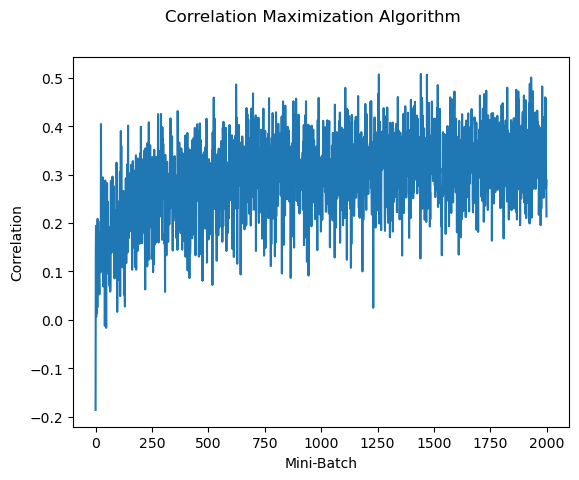

In [14]:
%matplotlib inline
plt.suptitle("Correlation Maximization Algorithm")
plt.ylabel("Correlation")
plt.xlabel("Mini-Batch")
plt.plot(validation_scores)

# Salvo i pesi

In [10]:
np.save("W_fine_%d.npy" % window, W)
np.save("Wf_fine_%d.npy" % window, Wf)

# Carico i pesi

In [34]:
window = 9
W  = np.load("W_%d.npy" % window)
Wf = np.load("Wf_%d.npy" % window)

# Test (singolo)

Data una voxelizzazione carico gli anchor point e ne calcolo la distanza con il punto di attachment.
Per testare la bontá del classificatore precedente viene analizzata la correlazione tra l'output e la distanza effettiva

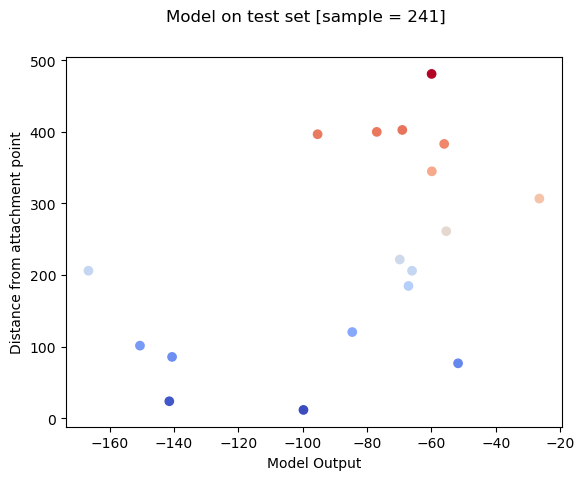

In [15]:
sample = np.arange(len(voxelizations))[indici_test][1]

def prediction_compare(sample):
    # dato un sample ritorna una matrice la cui prima colonna
    # rappresenta l'output del modello mentre la seconda
    # é la vera "inadeguatezza" degli anchor point
    
    
    # costrusico la voxgrid paddata
    Nx,Ny,Nz  = voxelizations[sample].shape
    curr_vox  = jnp.pad(
                    voxelizations[sample],
                    pad_width = (
                        (window,window),
                        (window,window),
                        (window,window)
                    )
                )

    # imposto la trasfromazione

    transform = SubvoxelgridTransform(window)

    points = []
    for a in anchors[sample]:
        
        correct_distance = jnp.sum( ( a - centers_of_mass[sample] )**2 )

        # trovo il voxel associato al punto di ancoraggip
        x_min,x_max,y_min,y_max,z_min,z_max = voxelization_specs[sample]
        x,y,z = a
        i,j,k = (
                 int( (x - x_min)/(x_max - x_min) * Nx ),
                 int( (y - y_min)/(y_max - y_min) * Ny ),
                 int( (z - z_min)/(z_max - z_min) * Nz )
        )

        # estraggo la subvoxelgrid
        subvox = transform.rotational_invariance(curr_vox[ 
                                (i+window) - window: (i+window) + window,
                                (j+window) - window: (j+window) + window,
                                (k+window) - window: (k+window) + window
                              ])
        # estraggo il farmaco
        f      = finger_prints[sample]
        Y_hat =  predict(W,Wf,subvox[None,:],f[None,:])[0]

        points.append([Y_hat,correct_distance])

    points = np.array(points)
    return points

points = prediction_compare(sample)
plt.xlabel("Model Output")
plt.ylabel("Distance from attachment point")
plt.suptitle("Model on test set [sample = %d]" % sample)
plt.scatter(points[:,0],points[:,1],c = points[:,1], cmap = 'coolwarm')

Si osservi come l'output del calssificatore sia effettivamente in grado di "correlare" con la distanza effettiva (punti vicini al punto di ancoraggio producono un output piccolo)

# Esempio

In [40]:
def norme_subvoxelgrids(sample):
    # dato un sample ritorna una matrice la cui prima colonna
    # rappresenta l'output del modello mentre la seconda
    # é la vera "inadeguatezza" degli anchor point
    
    
    # costrusico la voxgrid paddata
    Nx,Ny,Nz  = voxelizations[sample].shape
    curr_vox  = jnp.pad(
                    voxelizations[sample],
                    pad_width = (
                        (window,window),
                        (window,window),
                        (window,window)
                    )
                )

    # imposto la trasfromazione

    transform = SubvoxelgridTransform(window)
    rets = []
    
    for a in anchors[sample]:
        correct_distance = jnp.sum( ( a - centers_of_mass[sample] )**2 )

        # trovo il voxel associato al punto di ancoraggip
        x_min,x_max,y_min,y_max,z_min,z_max = voxelization_specs[sample]
        x,y,z = a
        i,j,k = (
                 int( (x - x_min)/(x_max - x_min) * Nx ),
                 int( (y - y_min)/(y_max - y_min) * Ny ),
                 int( (z - z_min)/(z_max - z_min) * Nz )
        )

        # estraggo la subvoxelgrid
        subvox = curr_vox[ 
                                (i+window) - window: (i+window) + window,
                                (j+window) - window: (j+window) + window,
                                (k+window) - window: (k+window) + window
                              ]
        
        rets.append(subvox[10,10,10] > 0.5)
        print(a, rets[-1]) 
    return 0

norme_subvoxelgrids(0)

[ 9.943 11.677 19.592] True
[ 9.943  5.677 26.592] True
[20.943 16.677 37.592] True
[ 7.943 16.677 29.592] True
[20.443 12.177 18.092] True
[ 5.943 -2.823 32.592] True
[ 2.443 17.677 17.592] True
[ 3.443 10.677 36.092] True
[17.443 -5.823 35.592] True
[ 0.943  2.677 24.592] True
[15.943 11.677 28.592] False
[12.943 18.677 35.592] True
[19.443  3.177 22.592] True
[25.443 -6.323 34.592] True
[ 0.943  2.177 38.592] False
[15.943 -6.823 21.592] True
[ 0.443 -7.323 22.092] True
[ 2.943  9.677 16.092] True
[14.443 19.177 25.092] False


0

# Test Globale

Il nostro modello produce fondamentalmente una "classifica" di bontá degli anchor points.
Per valutare la bontá del modello produciamo una confusion matrix definita in questo modo

Dato un set di <b>Anchor Points</b> $A$ e u Definiamo $C_{A,t} : A \rightarrow \{0,1\}$ la funzione che restituisce $0$ se l'anchor point é tra i primi $t$ piú vicini al punto di attachment, viceversa $1$ se é tra gli ultimi $|A| - t$ per vicinanza. <br>
<br>
<i>
<b> Definizione </b> (buon anchor point): Dato un set di anchor points $A$ e una soglia $t \in [1,|A|]$, $a \in A$ é detto un <b> buon anchor point se nella $C_{A,t}(a) = 0$</b> 
</i>
<br>
<br>
Parallelamente definiamo $\hat C_{A,t} : A \rightarrow \{0,1\}$ la funzione che, analogamente, resituisce $0$ se l'anchor point in ingresso é <b> predetto dal modello </b> come tra i primi $t$ piú vicini, viceversa $1$ se é tra gli ultimi $|A| - t$ per vicinanza <b> predetta</b>


<br>
Per valutare la bontá del nostro modello possiamo considerare la matrice $M$ cosí definita
<br><br>
<center>
$M^{(t)}_{ij} = \mathbb P[ \hat C_{A,t}(a) = i | C_{A,t}(a) = j  ]$
</center>
<br>
Che ha come elementi sulla diagonale le probabilitá di dare un risultato corretto in funzione del vero set di appartenenza dell'anchor point

In [16]:
soglia = 8

<AxesSubplot:>

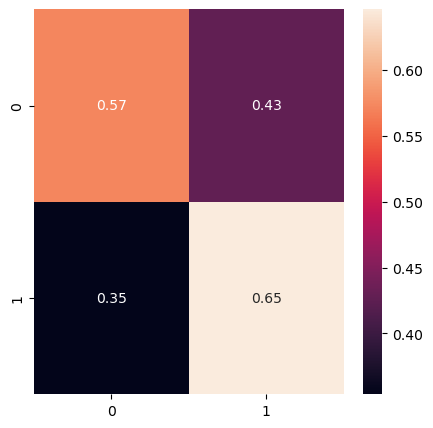

In [17]:
test_samples = np.arange(len(voxelizations))[indici_test]
M = np.zeros((2,2))

for sample in test_samples:
    #print("processing %d" % sample)
    points      = prediction_compare(sample)
    classifiche = points.argsort(axis = 0)
    for c in classifiche:
        i = c[0]
        j = c[1]
        if i >= soglia:
            i = 1
        else:
            i = 0
        if j >= soglia:
            j = 1
        else:
            j = 0
        M[i,j] += 1.

M = M / M.sum(axis = 0)[:,None]
        
import seaborn as sns
plt.figure(figsize = (5,5))
sns.heatmap(M, annot = True)
    

# Comparazione con Oracolo Randomico

Si definisce un <b>oracolo randomico</b> come una funzione $\mathscr O$ che prende in ingresso una <b> lista di anchor points </b> e restituisce <b> una classifica casuale </b>. <br>
Come ad esempio

In [18]:
def oracolo(A):
    classifica = np.random.choice(len(A),len(A),False)
    return classifica

Applichiamo lo stesso test globale sull'oracolo randomico per comparare le matrici di confusione

<AxesSubplot:>

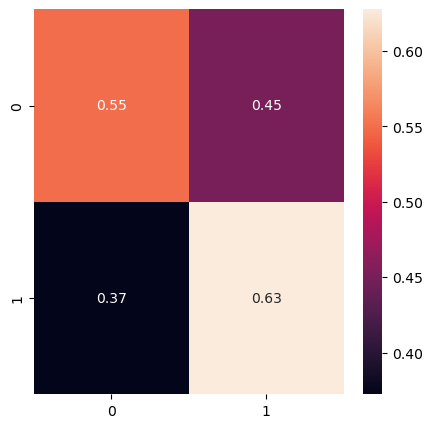

In [19]:
test_samples = np.arange(len(voxelizations))[indici_test]
M = np.zeros((2,2))

for sample in test_samples:
    #print("processing %d" % sample)
    points      = prediction_compare(sample)
    points[:,0] = oracolo(np.arange(len(points)))
    classifiche = points.argsort(axis = 0)
    for c in classifiche:
        i = c[0]
        j = c[1]
        if i >= soglia:
            i = 1
        else:
            i = 0
        if j >= soglia:
            j = 1
        else:
            j = 0
        M[i,j] += 1.

M = M / M.sum(axis = 0)[:,None]
        
import seaborn as sns
plt.figure(figsize = (5,5))
sns.heatmap(M, annot = True)
    

Si osservi che gli elementi sulla diagonale risultano inferiori rispetto all'esperimento basato sul modello. Questo a riprova del fatto che il modello é in grado di mappare buoni anchor point in predizioni positive

# One-choice Test

Un test piú intuitivo, che rappresenta meglio il caso di uso pratico dell'algoritmo é il <b> one-choice test </b>

<b> Definizione: </b> (One-choice test) Si definisce come One-choice il confronto tra le stime di probabilitá di selezionare un <b> buon anchor point </b> usando una policy casuale rispetto alla stima di probabilitá di selezionare un buon anchor point usando la policy definita implicitamente dal modello

<b> Definizione: </b> (Policy definita da un modello) Sia $\hat m$ un modello che prende in ingresso anchor points e restituisce una classifica. La policy definita dal modello ritorna con probabilitá $1$ il primo anchor point in classifica

<b> Remark </b> (Policy per un oracolo randomico) Dal momento che il modello rappresentato dall'oracolo randomico $\mathscr O$ restituisce una permutazione casuale degli anchor points come classifica, il primo in classifica é un anchor point casuale (con probabilitá di estrazione equidistribuita tra i vari anchor points)

Testiamo la bontá della predizione misurando la probabilitá che il migliore predetto dal modello sia tra i primi $t$.<br>
Definiamo lo stimatore $J$ tale che
<br><br>
<center>
$
J(\hat y)
\sim
\underbrace{
    \underset{a \in A}{\text{argmin}} \ \hat y(a) 
}_{\text{Selezionato dal modello}}    
   \in 
   \overbrace{ 
       A|_{C_{A,t}(A) = 0 }
   }^{
   \text{"Buoni" anchor point}
   }
$
</center>
Si osservi che <br>
<center>
    $\mathbb E[J(\hat y)] = \mathbb P [
    \underset{a \in A}{\text{argmin}} \ \hat y(a) 
   \in 
       A|_{C_{A,t}(A) = 0 }
]$
</center>

Chiamando nuovamente $\mathscr O$ l'oracolo randomico, vogliamo confrontare le variabili aleatorie $J(\hat y)$ e $J(\mathscr O)$<br> 
In particolare siamo interessati a valutare $\mathscr I(\hat y,\mathscr O) = J(\hat y) - J(\mathscr O)$  ovvero la variabile aleatoria che ci informa circa il miglioramento portato dal nostro algoritmo rispetto a una scelta casuale

In [20]:
test_samples = np.arange(len(voxelizations))[indici_test]

J = []
J_oracolo = []
print("Stimando J(y) e J(O)...")
for i,sample in enumerate(test_samples[np.random.choice(len(test_samples),size = 500,replace = True)]):
    points      = prediction_compare(sample)
    points      = points.argsort(axis = 0)
    scelto      = points[:,1][points[:,0].argmin()]
    curr_soglia = 2
    J.append( scelto < curr_soglia )
    scelto_rnd  = points[:,1][np.random.choice(len(points))]
    J_oracolo.append(scelto_rnd < curr_soglia)
print("Stima eseguita.")

Stimando J(y) e J(O)...
Stima eseguita.


Si osservi come la probabilitá di selezionare un <b> buon anchor point </b> risulti mediamente piú alta usando il modello

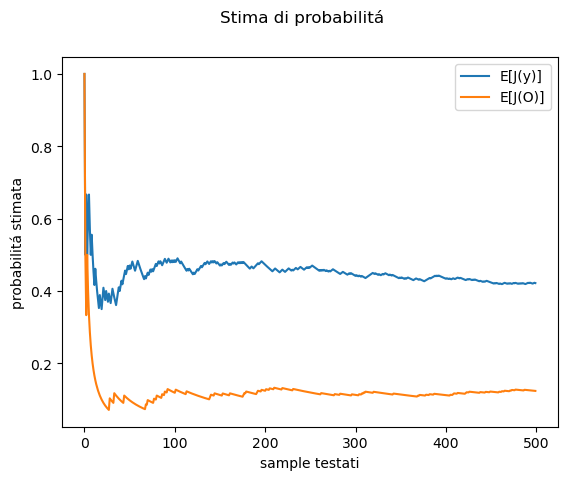

In [21]:
plt.suptitle("Stima di probabilitá")
plt.xlabel("sample testati")
plt.ylabel("probabilitá stimata")
plt.plot( np.cumsum(np.array(J))/(np.arange(len(J)) +1) )
plt.plot( np.cumsum(np.array(J_oracolo))/(np.arange(len(J_oracolo)) +1) )
plt.legend(['E[J(y)]','E[J(O)]'])
plt.show()

Possiamo anche visualizzare la stima per $\mathbb E[ \mathscr I(\hat y,\mathscr O) ]$

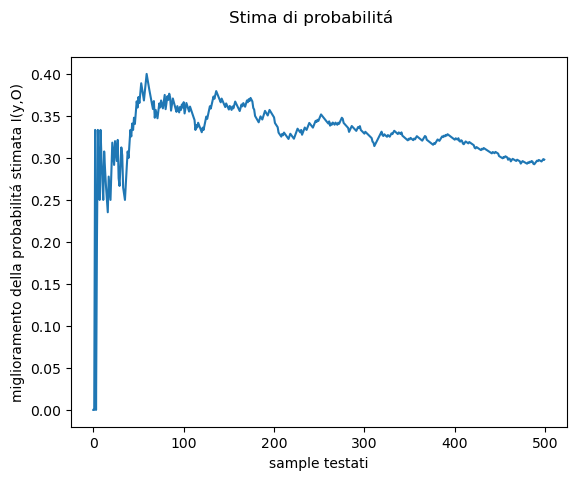

In [22]:
plt.suptitle("Stima di probabilitá")
plt.xlabel("sample testati")
plt.ylabel("miglioramento della probabilitá stimata I(y,O)")
plt.plot( np.cumsum(np.array(J)*1 - 1*np.array(J_oracolo))/(np.arange(len(J)) +1) )
plt.show()

# Average Amount of Attempts Test
Immaginiamo di avere una funzione $h_A : A \rightarrow \{0,1\}$ che restituisce $1$ se l'anchor point é quello piu vicino al punto di attachment, viceversa 0.
Testiamo quanti tentativi ci vogliono - mediamente - per trovare l'anchor point $a$ tale che $h_A(a) = 1$ usando rispettivamente la policy indotta dal nostro modello e la policy dell'oracolo casuale. (nella policy indotta dal modello partiamo da quelli predetti come piu vicini e li testiamo in ordine crescente, nella policy dell'oracolo casuale semplicemente tentiamo a caso)

In [23]:
def prediction_compare_oracolo(A,sample):
    classifica = np.random.choice(len(A),len(A),False)
    return np.c_[classifica, [ np.linalg.norm(c - A[c]) for c in classifica] ]

In [ ]:
test_samples = np.arange(len(voxelizations))[indici_test]

tentativi           = []
tentativi_oracolo   = []
print("Stimando J(y) e J(O)...")
for i,sample in enumerate(test_samples[np.random.choice(len(test_samples),size = 1000,replace = True)]):
    points      = prediction_compare(sample)
    points      = points.argsort(axis = 0)
    
    print(i)
    
    # riordino in funzione della predizione
    points      = points[points[:,0].argsort()]
    tentativi_curr =  ( (points[:,1] == 0).argmax() )
    tentativi.append(  (tentativi_curr * 1.) / len(points) )
    
    ############################################################
    
    points      = prediction_compare_oracolo(anchors[sample],sample)
    points      = points.argsort(axis = 0)

    # riordino in funzione della predizione
    points      = points[points[:,0].argsort()]
    tentativi_oracolo_curr =  ( (points[:,1] == 0).argmax() )
    tentativi_oracolo.append( (tentativi_oracolo_curr * 1.) / len(points) )
    
print("Stima eseguita.")

Stimando J(y) e J(O)...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
27

In [ ]:
from scipy import stats
bins = np.linspace(0,1,21)
plt.xticks(bins,rotation = 90)
plt.hist(np.array(tentativi), alpha = 0.25, bins = bins , density = True)
plt.hist(tentativi_oracolo, alpha = 0.25, bins = bins, density = True)
kde = stats.gaussian_kde(tentativi)
xx = np.linspace(0, 1, 1000)
plt.plot(xx, kde(xx), '--', color = 'blue', lw = 1.)

kde = stats.gaussian_kde(tentativi_oracolo)
xx = np.linspace(0, 1, 1000)
plt.plot(xx, kde(xx),'--', color = 'salmon', lw = 1.)
plt.ylabel("probability density")
plt.xlabel("percentuale degli anchor points da esplorare prima di trovare il migliore")

plt.scatter( np.mean(tentativi), 0 , color = 'blue', marker = (5,1), s = 100)
plt.scatter( np.mean(tentativi_oracolo), 0 , color = 'orange', marker = (5,1), s = 100)

plt.scatter( (np.mean(tentativi_oracolo) + np.mean(tentativi))/2., -.2 , color = 'white') # dumb scatter point
plt.legend(['pdf tentativi/numero a.p con policy del modello',
            'pdf tentativi/numero a.p con policy randomica',
            'expected value tentativi/numero a.p policy modello',
            'expected value tentativi/numero a.p policy randomica'
           ])
plt.show()
